# Model diagnostics

It is recommended to read [this tutorial](./single_phase_flow.ipynb) first.

PorePy is capable of running the multiphysics simulations of coupled processes in the mixed dimensional setting. That means in practice, that the model consists of multiple equations, each of which is defined on a set of subdomains or interfaces. The equations depend on model primary variables, which are defined on the corresponding subdomains and interfaces. The core of solution strategies to run the numerical simulation is solving a linear system of equations based on Jacobian matrix:
$$J_{ij}:=\frac{\partial F_i}{\partial x_j}$$
Here $F_i$ is any model equation after discretization, $x_j$ is any model primary variable in a discrete domain. The indices $i$ and $j$ run over the whole discrete computational domain and include all equations and variables in a model.

### Example:
Let's create a model including mass and energy balance with one fracture.

In [1]:
from typing import Literal
import numpy as np
import porepy as pp
from porepy.applications.md_grids.model_geometries import (
    SquareDomainOrthogonalFractures,
)
from porepy.models.mass_and_energy_balance import MassAndEnergyBalance


class MyModel(SquareDomainOrthogonalFractures, MassAndEnergyBalance):
    def meshing_arguments(self) -> dict:
        return {"cell_size": 0.25}

    def bc_values_darcy(self, subdomains: list[pp.Grid]) -> pp.ad.DenseArray:
        """Pressure = 1 on the west boundary of the domain and 0 elsewhere.

        Parameters:
            subdomains: List of subdomains on which to define boundary conditions.

        Returns:
            Array of boundary values.

        """
        # Define boundary regions
        if len(subdomains) == 0:
            return pp.wrap_as_ad_array(np.array([]), name="bc_values_darcy")
        values = []
        for sd in subdomains:
            bounds = self.domain_boundary_sides(sd)
            val_loc = np.zeros(sd.num_faces)
            # See section on scaling for explanation of the conversion.
            val_loc[bounds.west] = self.fluid.convert_units(1, "Pa")
            values.append(val_loc)
        return pp.wrap_as_ad_array(np.hstack(values), name="bc_values_darcy")

We're solving the model and plotting the pressure distribution.

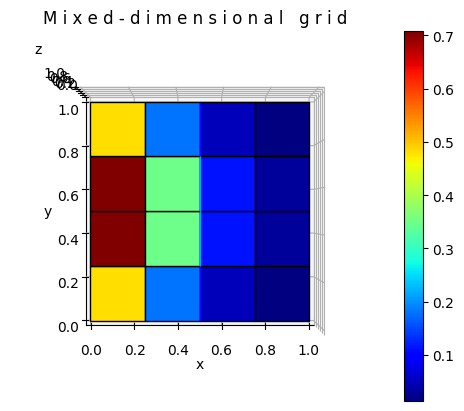

In [2]:
setup = MyModel({})
pp.run_time_dependent_model(setup, {})
pp.plot_grid(setup.mdg, cell_value=setup.pressure_variable)

The last assembled Jacobian can be accessed with the property `linear_system`.
Let's look at its sparsity pattern.

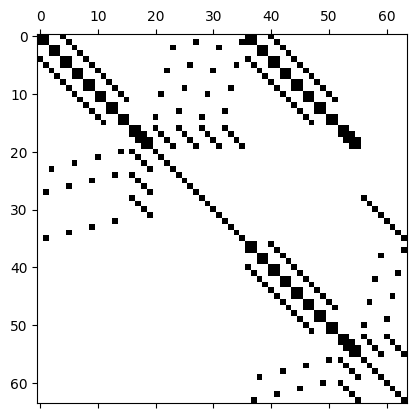

In [3]:
from matplotlib import pyplot as plt

jacobian, rhs = setup.linear_system

plt.spy(jacobian.toarray())

The image itself doesn't provide us with any useful information. However, studying the matrix is one way to debug the model you're working on.
The matrix consists of multiple blocks - the submatrices. Each block corresponds to the dependence of a specific equation on a specific variable. If there are multiple subdomains/interfaces, we can also divide each submatrix into grid-related blocks.

The list of equations used in this model:

In [4]:
for i, equation in enumerate(setup.equation_system.equations):
    print(f"{i}. {equation}")

0. energy_balance_equation
1. interface_fourier_flux_equation
2. interface_enthalpy_flux_equation
3. well_enthalpy_flux_equation
4. mass_balance_equation
5. interface_darcy_flux_equation
6. well_flux_equation


Here, one equation can be defined in multiple subdomains.

Now, we plot the list of variables. Note, that each variable corresponds to its own subdomain. That's why you'll see "temperature" and "pressure" twice - one of them is defined in the 2D subdomain, and the latter - in the 1D subdomain. 

In [5]:
for i, variable in enumerate(setup.equation_system.variables):
    print(f"{i}. {variable.name}")

0. temperature
1. temperature
2. interface_fourier_flux
3. interface_enthalpy_flux
4. pressure
5. pressure
6. interface_darcy_flux


## Diagnostics

The idea of the diagnostics is to monitor some integral value for each block. This value is called the "Condition number". Don't worry if you're not familiar with it. The things you need to know are that:
- it takes values in $[1, \infty]$.
- unity matrix has condition number = 1.
- degenerate matrices have condition number = $\infty$. 
- the smaller the condition number, the more accurately and easily we can solve a linear system numerically.

For more information, reference [Wikipedia](https://en.wikipedia.org/wiki/Condition_number).

We can compute the condition number for each submatrix of our Jacobian. A big condition number of a block can point out where to look for a bug or a reason for a performance decrease.

To run the diagnostics you need to add the diagnostics mixin to your model.

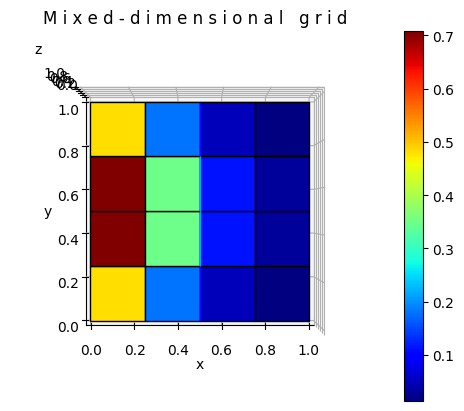

In [6]:
class MyModelWithDiagnostics(pp.DiagnosticsMixin, MyModel):
    pass


setup = MyModelWithDiagnostics({})
pp.run_time_dependent_model(setup, {})
pp.plot_grid(setup.mdg, cell_value=setup.pressure_variable)

The mixin provides the methods `run_diagnostics` and `plot_diagnostics`:

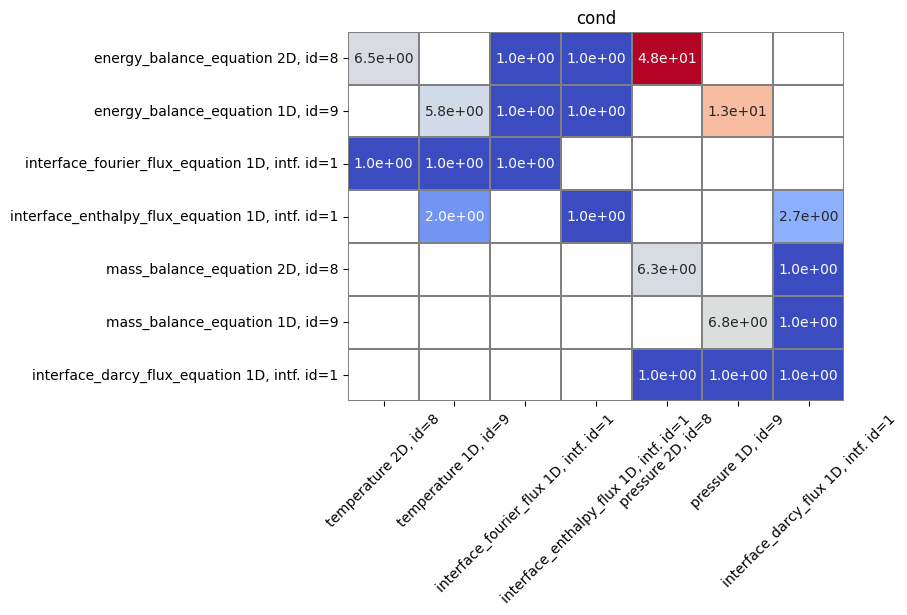

In [7]:
diagnostics_data = setup.run_diagnostics(
    default_handlers=("cond",),
)
setup.plot_diagnostics(
    diagnostics_data,
    key="cond",
)

Things to consider:
- Do your expectations of which equations depend on which variables (and on which grids) match what you see?
- Does any block have a much bigger condition value than the others? Is this expected?
- Maybe you should apply scaling to one of your model equations to decrease the condition number?

It is computationally expensive to compute the condition number for big matrices. In this case, you can use the simplified metric - the absolute maximum for each submatrix. It might provide less information about how bad the block is, but still a good thing to look at as a sanity check. If you need the condition number, it is recommended to decrease the model size. 

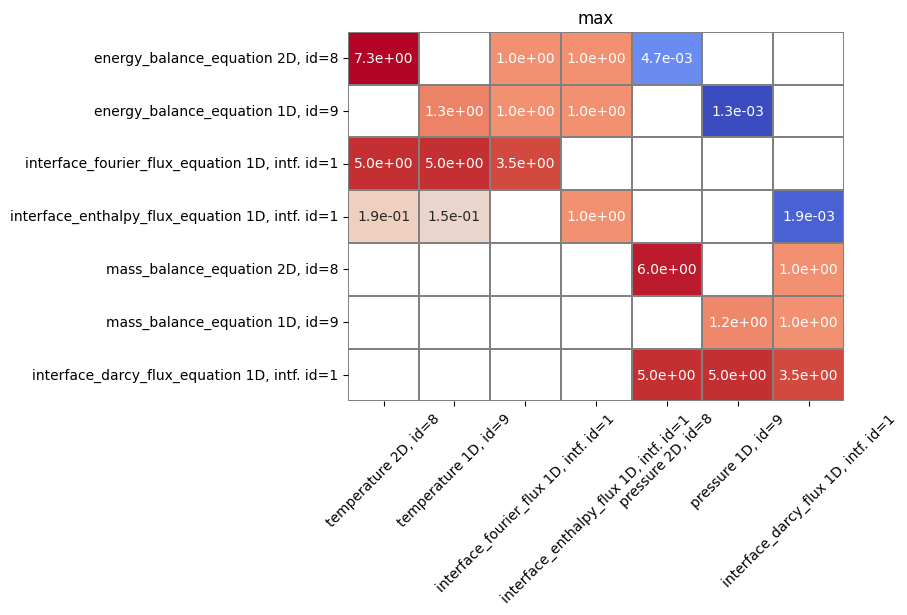

In [8]:
diagnostics_data = setup.run_diagnostics(
    default_handlers=("max",),
)
setup.plot_diagnostics(diagnostics_data, key="max")

# Grouping grids

If our model operates on a lot of grids, it might be difficult to visualize them all in one picture. Instead, we can gather the data from several grids into one cell, or only investigate those grids we are interested in. This is applied both to equations and variables.
To do so, we use the an argument `grouping`.

The possible values are:
- `grouping="dense"` - group all grids into one cell.
- `grouping="subdomains"` - investigate only the subdomains. Each subdomain is treated in a separate cell.
- `grouping="interfaces"` - the same as "subdomains", but for interfaces.
- custom - see further.

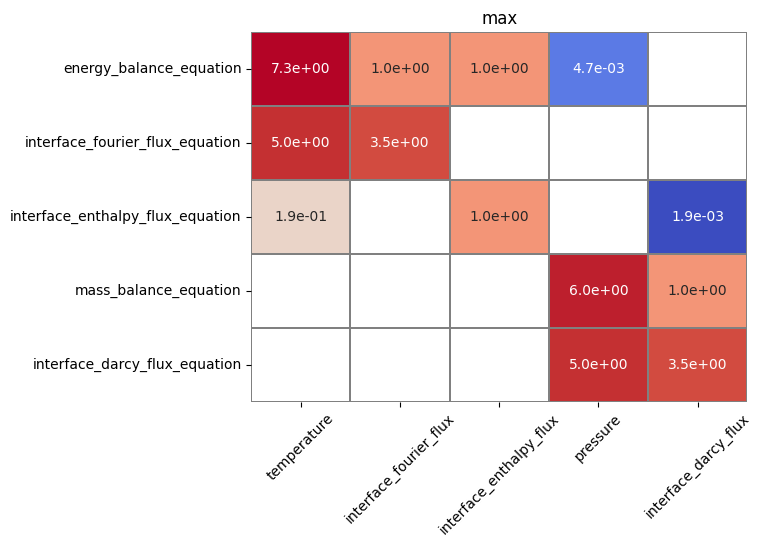

In [9]:
diagnostics_data = setup.run_diagnostics(grouping="dense")
setup.plot_diagnostics(diagnostics_data, key="max")

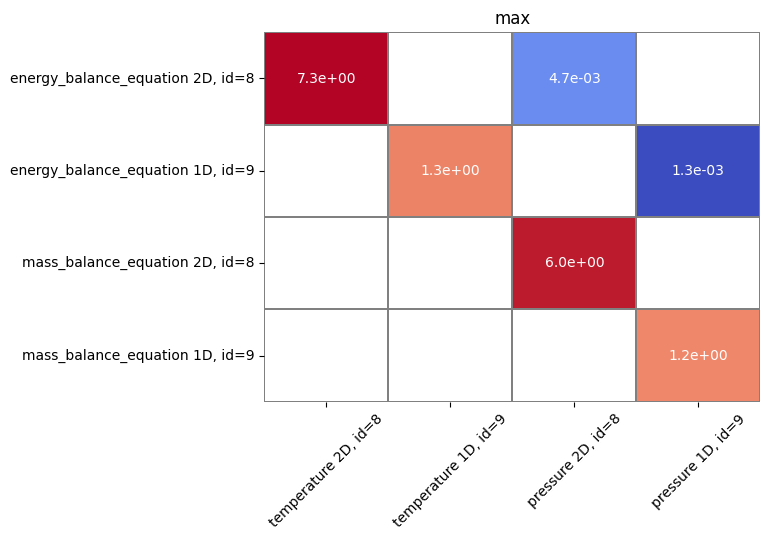

In [10]:
diagnostics_data = setup.run_diagnostics(grouping="subdomains")
setup.plot_diagnostics(diagnostics_data, key="max")

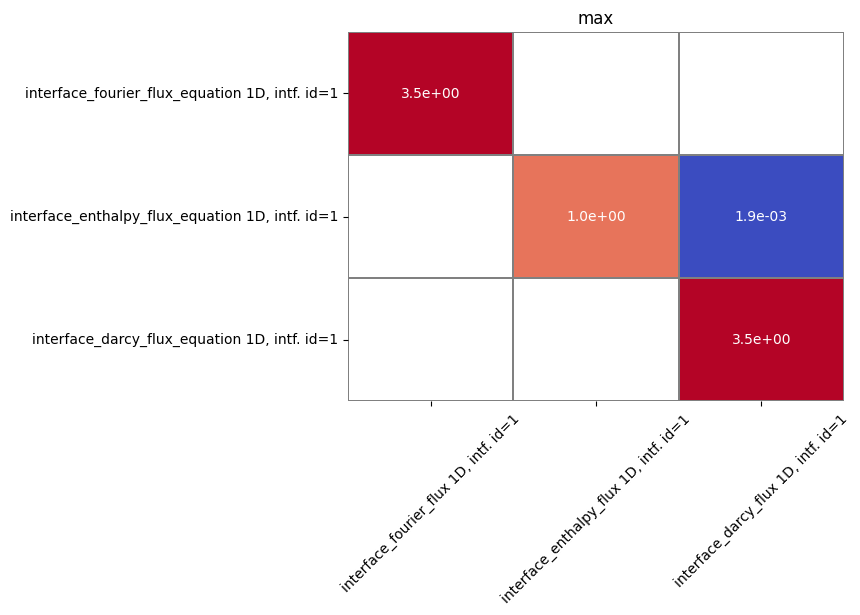

In [11]:
diagnostics_data = setup.run_diagnostics(grouping="interfaces")
setup.plot_diagnostics(diagnostics_data, key="max")

## Custom grouping

We can group grids however we want. For this, set the `grouping` argument with the list of lists of grids.
The outer list corresponds to separate blocks. The grids within one inner list are gathered to one cell.

For instance, let's investigate only the 1D subdomain and the interface:

In [12]:
subdomains = setup.mdg.subdomains()  # It includes [2D subdomain, 1D subdomain]
interfaces = setup.mdg.interfaces()
grouping = [[subdomains[1]], [interfaces[0]]]
grouping

[[Grid history: Compute geometry
  Number of cells 4
  Number of faces 5
  Number of nodes 5
  Dimension 1],
 [Mortar grid with history , mortar_grid and id 1.
  Dimension 1 and codimension 1
  Number of cells 8
  Number of sides 2
  Number of cells in lower-dimensional neighbor 4
  Number of faces in higher-dimensional neighbor 44]]

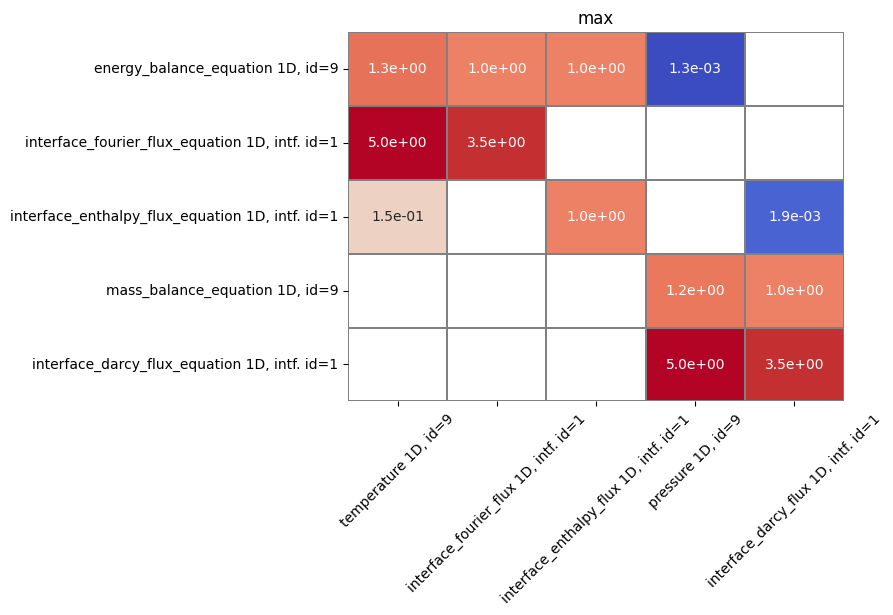

In [13]:
diagnostics_data = setup.run_diagnostics(grouping=grouping)
setup.plot_diagnostics(diagnostics_data, key="max")

# Custom handlers
We can add custom functions to be applied to each block for diagnostical purposes.
It can be done with `additional_handlers` argument. Provide it with the handler name and the function.

For example, we want to know the size of each block matrix (assuming they are square):

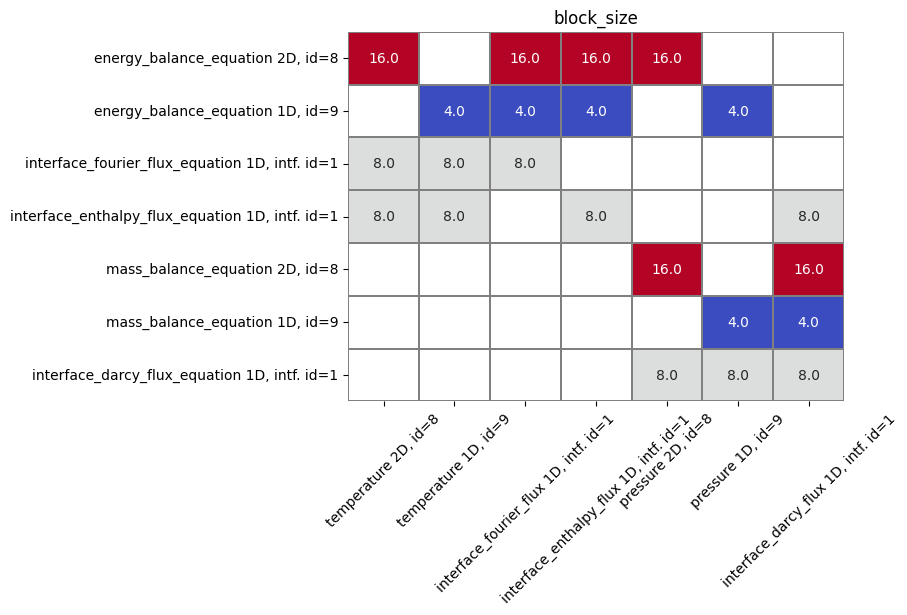

In [14]:
def get_block_size(mat, equation_name, variable_name):
    return mat.shape[0]


diagnostics_data = setup.run_diagnostics(
    additional_handlers={"block_size": get_block_size},
)

# The method allows passing additional keyword arguments to seaborn. Here, we pass "fmt"
# to prevent it from using scientific notation formatting.
setup.plot_diagnostics(
    diagnostics_data,
    key="block_size",
    fmt="",
)

All the information regarding the subdomains is returned from `run_diagnostics`. Here, we store in the `diagnostics_data`:

In [15]:
for key in diagnostics_data[0, 0].keys():
    print(key)

is_empty_block
variable_name
equation_name
equation_printed_name
variable_printed_name
block_dofs_row
block_dofs_col
block_size
max


# What have we explored

The diagnostics mixin allows for visualizing properties of the discretized system of equations blocks in PorePy. It is useful to take these properties into account when developing and debugging a new model, or optimizing the performance of an existing one.

We can group the blocks however we need and investigate only a subset of the grids we need.

We can add custom handlers for tailored diagnostics.